Investigate whether the Neutrino plot is present

In [44]:
import sqlite3

filename = "rasmus_classification_muon_3neutrino_3mio.db"
db_path = "C:/Users/jv97/Desktop/github/Neutrino-Machine-Learning/raw_data/{}".format(filename)

with sqlite3.connect(str(db_path)) as con:
    query = "SELECT energy_log10, zenith FROM truth WHERE pid IN (-14,14)"
    df = pd.read_sql(query,con)

In [54]:
transformer = pd.read_pickle('C:/Users/jv97/Desktop/github/Neutrino-Machine-Learning/datasets/transformers.pkl')

E = transformer['truth']['energy_log10'].inverse_transform(df.energy_log10.to_numpy().reshape(-1,1)).flatten()
ze = transformer['truth']['zenith'].inverse_transform(df.zenith.to_numpy().reshape(-1,1)).flatten()

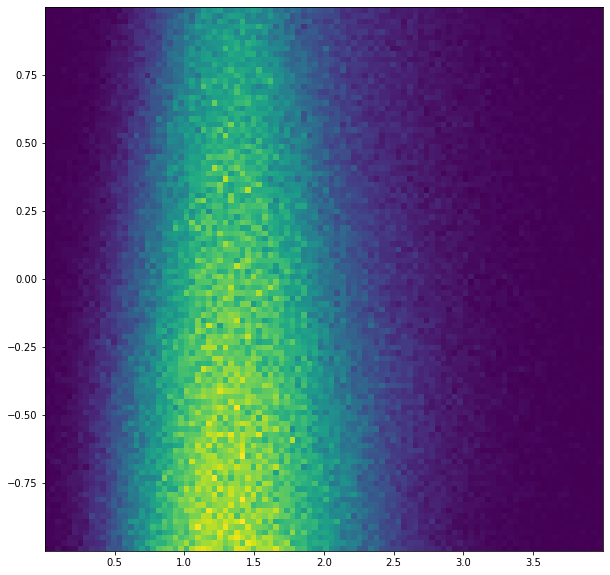

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist2d(E,np.cos(ze),bins=100);

In [11]:
import FunctionCollection as fc
import numpy as np
import matplotlib.pyplot as plt
import importlib
import torch
import pandas as pd

In [59]:
def target_constructor(dataset,transformer):
    E_ze_pid = dataset.data.y.view(-1,11,1)[:,[0,9,10]]
    dataset.data.y = torch.cat([torch.tensor(transformer['truth']['energy_log10'].inverse_transform(E_ze_pid[:,0]),dtype=torch.float),
                               torch.tensor(transformer['truth']['zenith'].inverse_transform(E_ze_pid[:,1]),dtype=torch.float),
                               E_ze_pid[:,2]],dim=1).flatten()
    dataset.slices['y'] = np.arange(0,len(dataset.data.y)+1,3)
    dataset = dataset[dataset.data.y.view(-1,3)[:,1].flatten() <= np.pi/2]
    dataset = dataset.reload()
    return dataset

def custom_target_constructor(dataset,transformer):
    tfs = transformer
    ze = torch.tensor(tfs['truth']['zenith'].inverse_transform(dataset.data.y.view(-1,11,1)[:,9]),dtype=torch.float)
    pid = dataset.data.y.view(-1,11)[:,10]
    y = torch.zeros(pid.shape[0],dtype=torch.long)
    y[pid == 14] += 1
    dataset.data.y = y.flatten()
    dataset.slices['y'] = np.arange(0,len(dataset.data.y)+1, 1)
    dataset = dataset[ze.flatten() <= np.pi/2]
    return dataset

In [60]:
fc = importlib.reload(fc)

name = '100k_EMu_neutrinos_set21.pt'
path = 'C:/Users/jv97/Desktop/github/Neutrino-Machine-Learning/datasets'
transformer = pd.read_pickle('C:/Users/jv97/Desktop/github/Neutrino-Machine-Learning/datasets/transformers.pkl')

dataset, train_loader, test_loader, val_loader = fc.dataset_preparator(name,
                                                                       path,
                                                                       transformer,
                                                                       target_constructor,
                                                                       fc.custom_feature_constructor,
                                                                       shuffle = False,
                                                                       TrTV_split = (0,1,1),
                                                                       batch_size = 1024)

2021-02-18 18:28:18.818979: loading data..
2021-02-18 18:28:19.000527: executing target constructor..
2021-02-18 18:28:26.825808: executing feature constructor..
tensor([[      0,       1,       2,  ..., 1150742, 1150743, 1150746],
        [      0,       0,       0,  ..., 1150746, 1150746, 1150746]])
2021-02-18 18:28:31.117705: defining dataloaders..
2021-02-18 18:28:31.117705: Done!


In [56]:
dataset

LoadDataset(42173)

In [4]:
import Models.Model11_2 as Model

device = torch.device('cuda')
model = Model.Net11().to(device)

state = torch.load('Trained_Models/Model11_2_EMuNeutrino_classification_2.pt')

model.load_state_dict(state['model_state_dict'])

<All keys matched successfully>

In [43]:
pred, true = fc.return_reco_truth(model,test_loader)

Batch: 100%|███████████████████████████████████| 98/98 [02:04<00:00,  1.06s/it]

In [44]:
mask = true[:,1] <= np.pi/2
pred[mask].argmax(1).sum()

0

In [45]:
(pred.argmax(1) == (true[:,2] == 14)).sum()/pred.shape[0]

0.50074

In [8]:
for dat in test_loader:
    break
dat = dat.to(device)
model.eval()
model(dat)

tensor([[  9.2561, -10.0483],
        [ 12.1888, -13.2639],
        [  7.3151,  -7.9224],
        [ 12.5320, -13.6422],
        [ 13.6123, -14.8287],
        [ 10.7633, -11.7000],
        [ 14.6201, -15.9342],
        [ 17.3793, -18.9626],
        [  5.6877,  -6.1420],
        [ 11.3924, -12.3928],
        [ 14.9120, -16.2570],
        [ 11.7932, -12.8299],
        [ 12.7395, -13.8706],
        [  8.4194,  -9.1319],
        [  9.6287, -10.4552],
        [ 12.0355, -13.1008],
        [  8.7082,  -9.4487],
        [  9.6520, -10.4823],
        [ 13.8007, -15.0373],
        [  9.1180,  -9.8996],
        [ 16.3458, -17.8308],
        [ 11.6874, -12.7161],
        [ 12.4040, -13.5013],
        [ 11.3987, -12.3977],
        [  6.6211,  -7.1616],
        [ 12.6298, -13.7524],
        [ 10.8716, -11.8203],
        [  9.6551, -10.4866],
        [ 10.4153, -11.3202],
        [ 11.0656, -12.0304],
        [ 10.7955, -11.7378],
        [  7.8530,  -8.5109],
        [ 19.0231, -20.7605],
        [ 

In [29]:
(pred.argmax(1) == (true[:,2] == 14)).sum()/pred.shape[0]

0.5200200558699234

In [50]:
(pred.argmax(1) == (true.flatten())).sum()/pred.shape[0]

0.9154549578587972

In [71]:
# E = dataset.data.y.view(-1,2)[:,0].numpy()
# ze = dataset.data.y.view(-1,2)[:,1].numpy()
E = true[:,0]
ze = true[:,1]

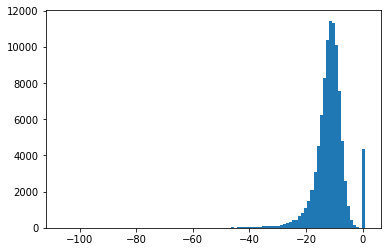

In [72]:
fig, ax = plt.subplots()
ax.hist(pred[:,1],bins=100);

In [11]:
pred[ze<np.pi/2]

array([[ 10.2784214 , -11.17549229],
       [  6.71443415,  -7.2671814 ],
       [ 15.52673817, -16.92765045],
       ...,
       [ 14.13622189, -15.41074753],
       [  6.06822729,  -6.56158018],
       [ 10.57112598, -11.49632263]])

In [15]:
true

array([[ 2.18841457,  3.06029916, 12.        ],
       [ 2.45466661,  1.48218286, 14.        ],
       [ 1.01502287,  1.78092718, 14.        ],
       ...,
       [ 1.44218683,  2.33539224, 12.        ],
       [ 1.51207137,  1.74630427, 12.        ],
       [ 1.74068427,  2.10316181, 12.        ]])

In [14]:
from sklearn.metrics import roc_auc_score

# roc_auc_score(true[ze<=np.pi/2,2] == 14, pred[ze<=np.pi/2,1])
roc_auc_score(true[:,0], pred[:,1])

0.9212943092842295

In [14]:
(pred[ze<np.pi/2].argmax(axis=1) == (true[ze<np.pi/2,2] == 14)).sum()/(ze<np.pi/2).sum()

0.5200200558699234

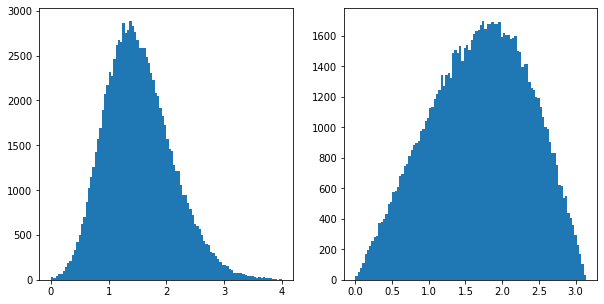

In [13]:
fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0].hist(E,bins=100);
ax[1].hist(ze,bins=100);

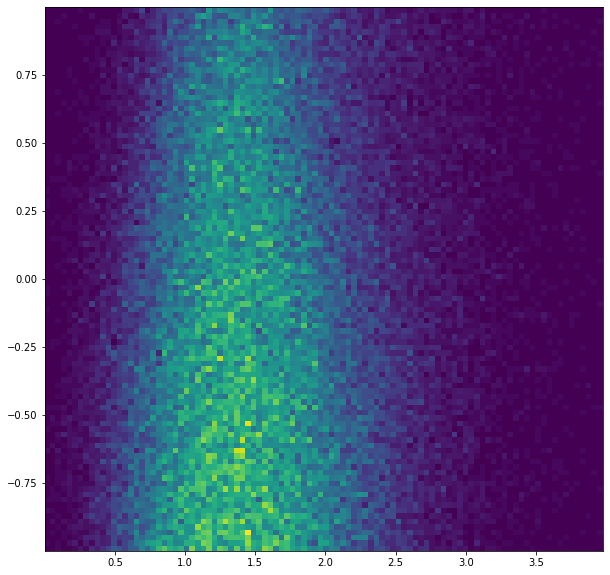

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist2d(E,np.cos(ze),bins=100);

In [22]:
# import Models.Model11_2 as Model
# device = torch.device('cuda')
# model = Model.Net11().to(device)

# state = torch.load('Trained_Models/Model11_SRT_and_corrected.pt')

# model.load_state_dict(state['model_state_dict'])